In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

import datetime
import os

In [2]:
### 데이터 로드
data = pd.read_csv('dataset/ethereum_dataset.csv', index_col=0)
data.head()

,Open*,High,Low,Close**,Volume,Market Cap
Date,,,,,,
2019-08-13,211.34,211.38,205.42,208.71,5946313205,2.239653e+10
2019-08-12,216.06,216.14,210.95,211.29,5674315559,2.267042e+10
2019-08-11,206.73,216.60,206.51,216.09,6440605605,2.318300e+10
2019-08-10,210.53,213.73,203.79,206.73,6584748527,2.217611e+10
2019-08-09,220.91,221.36,208.25,210.49,6964818795,2.257606e+10


In [3]:
## 정규화 함수
def normalize_windows(data):
    normalized_data = []

    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
        
    return np.array(normalized_data)

In [4]:
### 데이터 전처리
## price data
high_prices = data['High'].values
low_prices = data['Low'].values

mid_prices = (high_prices + low_prices) / 2

seq_len = 30
sequence_length = seq_len + 1

price = []
for index in range(len(mid_prices) - sequence_length):
    price.append(mid_prices[index: index + sequence_length])
    
norm_price = normalize_windows(price)

In [5]:
## volume data
volume_data = data['Volume'].values

volume = []
for index in range(len(volume_data) - sequence_length):
    volume.append(volume_data[index: index + sequence_length])
    
norm_volume = normalize_windows(volume)

In [6]:
def marge_data(price, volume):
    marged_data = []
    marge = []
    
    for p_index, v_index in zip(price, volume):
        for i in range(len(p_index)):
            marge.append(p_index[i])
            marge.append(v_index[i])
        
        marge.pop()
        marged_data.append(marge)
        marge = []
    
    return np.array(marged_data)

norm_result = marge_data(norm_price, norm_volume)
print(norm_result[0])

[ 0.          0.          0.0246881  -0.04574223  0.01513916  0.08312586
  0.00172745  0.10736658  0.03073417  0.17128354  0.06355566  0.12902321
  0.08550864  0.18062099  0.11005278  0.28613183  0.09942418  0.3058613
  0.0621881  -0.1190268   0.06034069 -0.04179304  0.0512476   0.03584188
  0.03579655  0.00321702  0.02948656  0.0096724   0.00882917 -0.07675249
  0.01413148 -0.07754764 -0.00602207 -0.07423512  0.02787908  0.05236702
  0.04215451 -0.03640256  0.05659789  0.13200918  0.01110845  0.2056181
  0.02725528  0.1731793   0.05640595  0.06601245  0.07699136  0.12423995
  0.09258637  0.3413767   0.06233205  0.27918474  0.04913628  0.56867217
 -0.01158829  0.57875095  0.03620441  0.5197014   0.06866603  0.63524421
  0.1922025 ]


In [7]:
train_cut = -90 # 마지막 3달의 데이터를 test데이터로 한다
        
train = norm_result[:train_cut, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = norm_result[train_cut:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = norm_result[train_cut:, -1]

x_train.shape, x_test.shape

((1347, 60, 1), (90, 60, 1))

In [8]:
### 모델 체크포인터 롤백
MODEL_SAVE_FOLBER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

In [31]:
### 모델 설계
model = Sequential()

model.add(Conv1D(30, 2, activation='relu',strides=2, input_shape=(60,1)))
# model.add(MaxPooling1D(pool_size=2))
for i in range (4):
    model.add(LSTM(30, return_sequences=True))   

model.add(LSTM(30, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 30, 30)            90        
_________________________________________________________________
lstm_73 (LSTM)               (None, 30, 30)            7320      
_________________________________________________________________
lstm_74 (LSTM)               (None, 30, 30)            7320      
_________________________________________________________________
lstm_75 (LSTM)               (None, 30, 30)            7320      
_________________________________________________________________
lstm_76 (LSTM)               (None, 30, 30)            7320      
_________________________________________________________________
lstm_77 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 31        
Total para

In [32]:
### 모델 학습
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=30, callbacks=[cb_checkpoint])

W0827 14:52:47.609390  6712 deprecation.py:323] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0827 14:52:49.733976  6712 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0827 14:52:49.738976  6712 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1347 samples, validate on 90 samples
Epoch 1/30
1347/1347 [==============================] - 25s 18ms/step - loss: 0.0702 - val_loss: 0.1210

Epoch 00001: val_loss improved from inf to 0.12099, saving model to ./model/01-0.1210.hdf5
Epoch 2/30
1347/1347 [==============================] - 11s 8ms/step - loss: 0.0357 - val_loss: 0.1112

Epoch 00002: val_loss improved from 0.12099 to 0.11125, saving model to ./model/02-0.1112.hdf5
Epoch 3/30
1347/1347 [==============================] - 10s 8ms/step - loss: 0.0279 - val_loss: 0.1082

Epoch 00003: val_loss improved from 0.11125 to 0.10824, saving model to ./model/03-0.1082.hdf5
Epoch 4/30
1347/1347 [==============================] - 11s 8ms/step - loss: 0.0260 - val_loss: 0.1156

Epoch 00004: val_loss did not improve from 0.10824
Epoch 5/30
1347/1347 [==============================] - 11s 8ms/step - loss: 0.0217 - val_loss: 0.0949

Epoch 00005: val_loss improved from 0.10824 to 0.09490, saving model to ./model/05-0.0949.hdf5
Epoch 

In [ ]:
### 학습 모델 로드
# model = load_model('ether_prediction_model_achi_1.h5')
# model = load_model('ether_prediction_model_achi_2.h5')
model = load_model('ether_prediction_model_achi_3.h5')

In [33]:
## 모델 저장
model. save('ether_prediction_model_achi_3.h5')

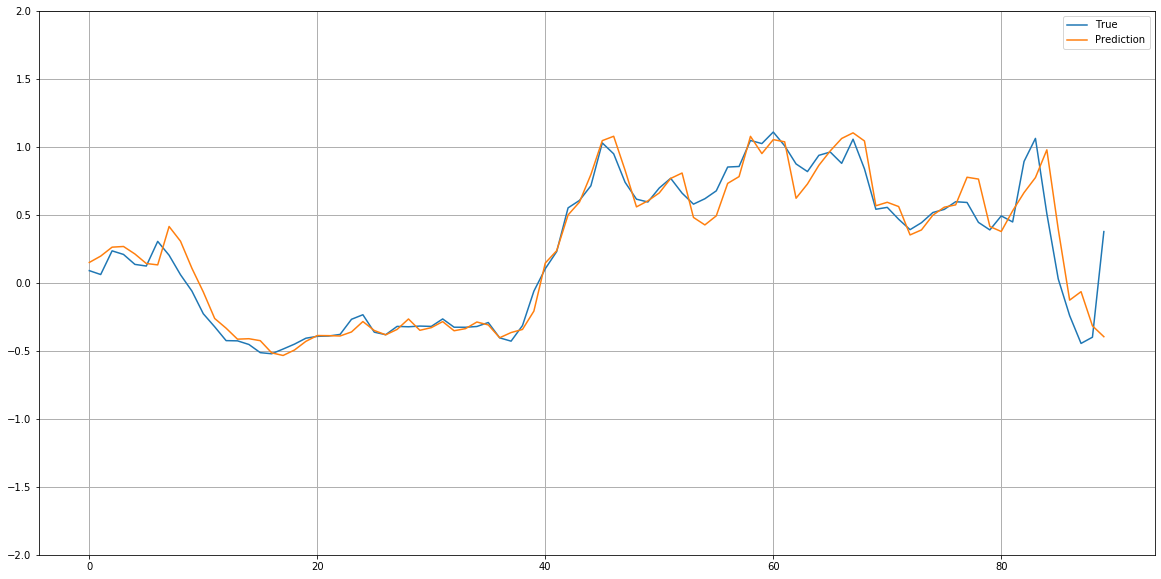

In [34]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
ax.grid(linestyle='-', linewidth=1,)
plt.ylim([-2, 2])
plt.show()